# Analysis of our data

1. Data collecting and data cleaning 
2. Computations for the creation of the adjacency matrix and the graph
3. Graph creation
4. Analysis

In [2]:
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas.plotting import scatter_matrix
from pandas.io.json import json_normalize
import pickle
import re
import scipy as sp
from scipy import stats
import seaborn as sns
from sklearn import metrics
from sklearn.cluster import DBSCAN
from sklearn.datasets.samples_generator import make_blobs
from sklearn.decomposition import PCA
from sklearn.feature_selection import mutual_info_regression
from sklearn.preprocessing import StandardScaler
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning)
pd.options.mode.chained_assignment = None
import datetime
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

import omdb

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/iciarllorensjover/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/iciarllorensjover/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [3]:
%matplotlib inline

# 1. Data collecting and data cleaning

In [14]:
#import dataset
FILE_PATH_CREW = "../Data/tmdb_5000_credits.csv"

features_crew = pd.read_csv(FILE_PATH_CREW)

# Dataframe with info about the movies
features_crew.head()

,movie_id,title,cast,crew
0,19995,Avatar,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."
1,285,Pirates of the Caribbean: At World's End,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de..."
2,206647,Spectre,"[{""cast_id"": 1, ""character"": ""James Bond"", ""cr...","[{""credit_id"": ""54805967c3a36829b5002c41"", ""de..."
3,49026,The Dark Knight Rises,"[{""cast_id"": 2, ""character"": ""Bruce Wayne / Ba...","[{""credit_id"": ""52fe4781c3a36847f81398c3"", ""de..."
4,49529,John Carter,"[{""cast_id"": 5, ""character"": ""John Carter"", ""c...","[{""credit_id"": ""52fe479ac3a36847f813eaa3"", ""de..."


In [22]:
#specify your API_KEY used to set client
API_y_KEY = '3a7e30ce'
omdb.set_default('apikey', API_y_KEY)
client = omdb.OMDBClient(apikey=API_y_KEY)

In [70]:
#We have a 1000 request limit so you can decide here at which film you want to start and where to end 
id_end = 4803
id_start = id_end - 1000

In [74]:
#creates empty dictionary then updates it using the movie_id as a key and the output of the
#request as value (note that that res.content isn't actually a dict but a byte object, we may
#need to convert it later)

collected = dict()

for i in range(id_start, id_end):
    title = features_crew.title[i]
    res = omdb.request(t=title, tomatoes=True)
    movie_json = res.content
    collected[str(features_crew.movie_id[i])] = movie_json

In [83]:
# saves collected as pickle
with open('metacrit.p', 'wb') as fp:
    pickle.dump(collected, fp, protocol=pickle.HIGHEST_PROTOCOL)

In [5]:
# loads collected
with open('metacrit.p', 'rb') as fp:
    test_data = pickle.load(fp)

# 2. Computations for the creation of the adjacency matrix and the graph

In [6]:
df = pd.DataFrame.from_dict(test_data, orient='index')
df.head()

,0
19995,"b'{""Title"":""Avatar"",""Year"":""2009"",""Rated"":""PG-..."
285,"b'{""Title"":""Pirates of the Caribbean: At World..."
206647,"b'{""Title"":""Spectre"",""Year"":""2015"",""Rated"":""PG..."
49026,"b'{""Title"":""The Dark Knight Rises"",""Year"":""201..."
49529,"b'{""Title"":""John Carter"",""Year"":""2012"",""Rated""..."


In [7]:
dataframe = pd.read_json(df.iloc[0].values[0])

for i in range(1, len(df)):
    if len(df.iloc[i].values[0]) > 100:
        movie = pd.read_json(df.iloc[i].values[0])
    dataframe = pd.concat([dataframe, movie])

In [8]:
# We decided to drop the useless columns that did not contain information about the movie
# These columns are: - urls (Poster, Website, tomatoImage)
#                    - columns related to the API (Response, Type)
#                    - columns where all entries are NaN
#                    - Irrelevant columns (DVD, ie release date of dvd)
#                    - Redundant columns (Year is redundant with Released)

dataframe = dataframe.drop(columns=['Poster', 'Response', 'Type', 'Website', 'tomatoConsensus', 
                                    'tomatoFresh', 'tomatoImage', 'tomatoMeter', 'tomatoRating', 
                                    'tomatoReviews', 'tomatoRotten', 'tomatoURL', 'tomatoUserMeter', 
                                    'tomatoUserRating', 'tomatoUserReviews', 'totalSeasons', 'DVD', 'Year'])
dataframe.head()

,Actors,Awards,BoxOffice,Country,Director,Genre,Language,Metascore,Plot,Production,Rated,Ratings,Released,Runtime,Title,Writer,imdbID,imdbRating,imdbVotes
0,"Sam Worthington, Zoe Saldana, Sigourney Weaver...",Won 3 Oscars. Another 85 wins & 128 nominations.,"$749,700,000","UK, USA",James Cameron,"Action, Adventure, Fantasy, Sci-Fi","English, Spanish",83,A paraplegic marine dispatched to the moon Pan...,20th Century Fox,PG-13,"{'Source': 'Internet Movie Database', 'Value':...",18 Dec 2009,162 min,Avatar,James Cameron,tt0499549,7.8,"1,013,715"
1,"Sam Worthington, Zoe Saldana, Sigourney Weaver...",Won 3 Oscars. Another 85 wins & 128 nominations.,"$749,700,000","UK, USA",James Cameron,"Action, Adventure, Fantasy, Sci-Fi","English, Spanish",83,A paraplegic marine dispatched to the moon Pan...,20th Century Fox,PG-13,"{'Source': 'Rotten Tomatoes', 'Value': '82%'}",18 Dec 2009,162 min,Avatar,James Cameron,tt0499549,7.8,"1,013,715"
2,"Sam Worthington, Zoe Saldana, Sigourney Weaver...",Won 3 Oscars. Another 85 wins & 128 nominations.,"$749,700,000","UK, USA",James Cameron,"Action, Adventure, Fantasy, Sci-Fi","English, Spanish",83,A paraplegic marine dispatched to the moon Pan...,20th Century Fox,PG-13,"{'Source': 'Metacritic', 'Value': '83/100'}",18 Dec 2009,162 min,Avatar,James Cameron,tt0499549,7.8,"1,013,715"
0,"Johnny Depp, Geoffrey Rush, Orlando Bloom, Kei...",Nominated for 2 Oscars. Another 20 wins & 44 n...,"$309,404,152",USA,Gore Verbinski,"Action, Adventure, Fantasy",English,50,"Captain Barbossa, Will Turner and Elizabeth Sw...",Buena Vista,PG-13,"{'Source': 'Internet Movie Database', 'Value':...",25 May 2007,169 min,Pirates of the Caribbean: At World's End,"Ted Elliott, Terry Rossio, Ted Elliott (charac...",tt0449088,7.1,"542,125"
1,"Johnny Depp, Geoffrey Rush, Orlando Bloom, Kei...",Nominated for 2 Oscars. Another 20 wins & 44 n...,"$309,404,152",USA,Gore Verbinski,"Action, Adventure, Fantasy",English,50,"Captain Barbossa, Will Turner and Elizabeth Sw...",Buena Vista,PG-13,"{'Source': 'Rotten Tomatoes', 'Value': '44%'}",25 May 2007,169 min,Pirates of the Caribbean: At World's End,"Ted Elliott, Terry Rossio, Ted Elliott (charac...",tt0449088,7.1,"542,125"


We now need to transform the types so that it is easier to analyze the features. As of now, almost all the entries of our dataframe are strings. We have a few entries that are integer numbers that need to be converted: BoxOffice, Metascore, Runtime and imdbVotes.

Metascore is already in an appropriate format, we just need to cast the type. However, BoxOffice, Runtime and imdbVotes need a little bit of tinkering.

In [9]:
# For BoxOffice we need to remove the $ and commas
dataframe['BoxOffice'] = dataframe['BoxOffice'].apply(lambda x: x.replace("$", ""))
dataframe['BoxOffice'] = dataframe['BoxOffice'].apply(lambda x: x.replace(",", ""))
dataframe['BoxOffice'] = dataframe['BoxOffice'].replace('N/A', 0)
dataframe['BoxOffice'] = dataframe['BoxOffice'].astype(float)
dataframe['BoxOffice'] = dataframe['BoxOffice'].astype(int)
# For imdbVotes we need to remove the commas
dataframe['imdbVotes'] = dataframe['imdbVotes'].astype(str)
dataframe['imdbVotes'] = dataframe['imdbVotes'].apply(lambda x: x.replace(",", ""))
dataframe['imdbVotes'] = dataframe['imdbVotes'].replace('N/A', 0)
dataframe['imdbVotes'] = dataframe['imdbVotes'].astype(int)
# For Runtime we need to remove the " min"
dataframe['Runtime'] = dataframe['Runtime'].apply(lambda x: x.replace(" min", ""))
dataframe['Runtime'] = dataframe['Runtime'].replace('N/A', 0)
dataframe['Runtime'] = dataframe['Runtime'].astype(int)
# Metascore
dataframe['Metascore'] = dataframe['Metascore'].replace('N/A', 0)
dataframe['Metascore'] = dataframe['Metascore'].astype(int)

dataframe = dataframe.reset_index(drop=True)

In [10]:
dataframe.head()

,Actors,Awards,BoxOffice,Country,Director,Genre,Language,Metascore,Plot,Production,Rated,Ratings,Released,Runtime,Title,Writer,imdbID,imdbRating,imdbVotes
0,"Sam Worthington, Zoe Saldana, Sigourney Weaver...",Won 3 Oscars. Another 85 wins & 128 nominations.,749700000,"UK, USA",James Cameron,"Action, Adventure, Fantasy, Sci-Fi","English, Spanish",83,A paraplegic marine dispatched to the moon Pan...,20th Century Fox,PG-13,"{'Source': 'Internet Movie Database', 'Value':...",18 Dec 2009,162,Avatar,James Cameron,tt0499549,7.8,1013715
1,"Sam Worthington, Zoe Saldana, Sigourney Weaver...",Won 3 Oscars. Another 85 wins & 128 nominations.,749700000,"UK, USA",James Cameron,"Action, Adventure, Fantasy, Sci-Fi","English, Spanish",83,A paraplegic marine dispatched to the moon Pan...,20th Century Fox,PG-13,"{'Source': 'Rotten Tomatoes', 'Value': '82%'}",18 Dec 2009,162,Avatar,James Cameron,tt0499549,7.8,1013715
2,"Sam Worthington, Zoe Saldana, Sigourney Weaver...",Won 3 Oscars. Another 85 wins & 128 nominations.,749700000,"UK, USA",James Cameron,"Action, Adventure, Fantasy, Sci-Fi","English, Spanish",83,A paraplegic marine dispatched to the moon Pan...,20th Century Fox,PG-13,"{'Source': 'Metacritic', 'Value': '83/100'}",18 Dec 2009,162,Avatar,James Cameron,tt0499549,7.8,1013715
3,"Johnny Depp, Geoffrey Rush, Orlando Bloom, Kei...",Nominated for 2 Oscars. Another 20 wins & 44 n...,309404152,USA,Gore Verbinski,"Action, Adventure, Fantasy",English,50,"Captain Barbossa, Will Turner and Elizabeth Sw...",Buena Vista,PG-13,"{'Source': 'Internet Movie Database', 'Value':...",25 May 2007,169,Pirates of the Caribbean: At World's End,"Ted Elliott, Terry Rossio, Ted Elliott (charac...",tt0449088,7.1,542125
4,"Johnny Depp, Geoffrey Rush, Orlando Bloom, Kei...",Nominated for 2 Oscars. Another 20 wins & 44 n...,309404152,USA,Gore Verbinski,"Action, Adventure, Fantasy",English,50,"Captain Barbossa, Will Turner and Elizabeth Sw...",Buena Vista,PG-13,"{'Source': 'Rotten Tomatoes', 'Value': '44%'}",25 May 2007,169,Pirates of the Caribbean: At World's End,"Ted Elliott, Terry Rossio, Ted Elliott (charac...",tt0449088,7.1,542125


Now, we need to regroup the different sources of ratings so that the movies are not repeated three times in the dataframe.

- The first rating comes from imdb, its value is on a scale from 0 to 10
- The second rating comes from Rotten Tomatoes, its value is a percentage
- The third rating comes from Metacritic, its value is on a scale from 0 to 100

We wish to separate this column into 3 columns, drop the duplicate rows and convert the ratings to percentages for a more uniform notation.

In [11]:
dataframe_ = dataframe.copy()

In [12]:
# Create columns
dataframe_['imdbGrade'] = 0
dataframe_['tomatoGrade'] = 0
dataframe_['metacriticGrade'] = 0

# Fill columns
for i in range(0, int(len(dataframe)/3)):
    dataframe_['tomatoGrade'][3*i] = dataframe_['Ratings'][3*i+1]['Value']

# Drop rows
dataframe_ = dataframe_[dataframe_['tomatoGrade'] != 0]

In [13]:
dataframe_ = dataframe_.reset_index(drop=True)

In [14]:
# Transform grades
dataframe_['imdbGrade'] = dataframe_['imdbRating']*10
dataframe_ = dataframe_.drop(columns=['imdbRating'])

for i in range(0, len(dataframe_)):
    if '/10' in dataframe_['tomatoGrade'][i]:
        grade_ = dataframe_['tomatoGrade'][i].replace('/10', '').replace('.', '')
        dataframe_['tomatoGrade'][i] = int(grade)
    elif '%' in dataframe_['tomatoGrade'][i]:
        grade = dataframe_['tomatoGrade'][i].replace('%', '')
        dataframe_['tomatoGrade'][i] = int(grade)
    elif '/100' in dataframe_['metacriticGrade'][i]:
        grade = dataframe_['metacriticGrade'][i].replace('/100', '')
        dataframe_['metacriticGrade'][i] = int(grade)
    else:
        grade = float(dataframe_['tomatoGrade'][i])
        if grade > 100:
            grade = grade / 10
        dataframe_['tomatoGrade'][i] = int(grade)

dataframe_['metacriticGrade'] = dataframe_['Metascore']
dataframe_ = dataframe_.drop(columns=['Metascore'])

In [15]:
dataframe_['imdbGrade'] = dataframe_['imdbGrade'].astype(int)
dataframe_['tomatoGrade'] = dataframe_['tomatoGrade'].astype(int)
dataframe_['metacriticGrade'] = dataframe_['metacriticGrade'].astype(int)
dataframe_ = dataframe_.drop(columns=['Ratings'])

In [16]:
dataframe_.head()

,Actors,Awards,BoxOffice,Country,Director,Genre,Language,Plot,Production,Rated,Released,Runtime,Title,Writer,imdbID,imdbVotes,imdbGrade,tomatoGrade,metacriticGrade
0,"Sam Worthington, Zoe Saldana, Sigourney Weaver...",Won 3 Oscars. Another 85 wins & 128 nominations.,749700000,"UK, USA",James Cameron,"Action, Adventure, Fantasy, Sci-Fi","English, Spanish",A paraplegic marine dispatched to the moon Pan...,20th Century Fox,PG-13,18 Dec 2009,162,Avatar,James Cameron,tt0499549,1013715,78,82,83
1,"Johnny Depp, Geoffrey Rush, Orlando Bloom, Kei...",Nominated for 2 Oscars. Another 20 wins & 44 n...,309404152,USA,Gore Verbinski,"Action, Adventure, Fantasy",English,"Captain Barbossa, Will Turner and Elizabeth Sw...",Buena Vista,PG-13,25 May 2007,169,Pirates of the Caribbean: At World's End,"Ted Elliott, Terry Rossio, Ted Elliott (charac...",tt0449088,542125,71,44,50
2,"Daniel Craig, Christoph Waltz, Léa Seydoux, Ra...",Won 1 Oscar. Another 7 wins & 32 nominations.,208777731,"UK, USA",Sam Mendes,"Action, Adventure, Thriller","English, Spanish, Italian, German, French",A cryptic message from 007's past sends him pi...,Sony Pictures,PG-13,06 Nov 2015,148,Spectre,"John Logan (screenplay by), Neal Purvis (scree...",tt2379713,343533,68,64,60
3,"Christian Bale, Gary Oldman, Tom Hardy, Joseph...",Nominated for 1 BAFTA Film Award. Another 38 w...,448130642,"UK, USA",Christopher Nolan,"Action, Thriller","English, Arabic",Eight years after the Joker's reign of anarchy...,Warner Bros. Pictures,PG-13,20 Jul 2012,164,The Dark Knight Rises,"Jonathan Nolan (screenplay), Christopher Nolan...",tt1345836,1344474,84,87,78
4,"Taylor Kitsch, Lynn Collins, Samantha Morton, ...",2 wins & 8 nominations.,73058679,USA,Andrew Stanton,"Action, Adventure, Sci-Fi",English,"Transported to Barsoom, a Civil War vet discov...",Walt Disney Pictures,PG-13,09 Mar 2012,132,John Carter,"Andrew Stanton (screenplay by), Mark Andrews (...",tt0401729,234717,66,51,51


Now, we need to deal with the string attributes that are in form of a list. We want a set of strings, each string corresponding to an individual characteristic (country, actor, etc).

In order to do so, we split the string at the commas. For the Writer attribute, we decided to remove the specifications and only keep the names of the writers, taking off who wrote the story, screenplay or characters.

In [17]:
dataframe_['Actors'] = dataframe_['Actors'].apply(lambda x: set(x.split(', ')))
dataframe_['Country'] = dataframe_['Country'].apply(lambda x: set(x.split(', ')))
dataframe_['Director'] = dataframe_['Director'].apply(lambda x: set(x.split(', ')))
dataframe_['Genre'] = dataframe_['Genre'].apply(lambda x: set(x.split(', ')))
dataframe_['Language'] = dataframe_['Language'].apply(lambda x: set(x.split(', ')))

In [18]:
dataframe_['Writer'] = dataframe_['Writer'].apply(lambda x: re.sub(" [\(\[].*?[\)\]]", "", x))
dataframe_['Writer'] = dataframe_['Writer'].apply(lambda x: set(x.split(', ')))

In [106]:
oscars_df = pd.read_csv('../Data/oscars.csv')
# Actor & actress (supporting or Leading role)
# Directing, Directing (Comedy Picture), Directing (Dramatic Picture)
# All the Writings

set(oscars_df.Award)
oscars_df.Year = oscars_df.Year.apply(lambda x: int(x[0:4]) if len(x) > 4 else int(x))
oscars_df= oscars_df[oscars_df.Year.apply(lambda x: x > 1930)].dropna()

In [108]:
oscars_df.head()

,Year,Ceremony,Award,Winner,Name,Film
159,1931,5,Actor,1.0,Wallace Beery,The Champ
161,1931,5,Actor,1.0,Fredric March,Dr. Jekyll and Mr. Hyde
164,1931,5,Actress,1.0,Helen Hayes,The Sin of Madelon Claudet
167,1931,5,Art Direction,1.0,Transatlantic,Gordon Wiles
170,1931,5,Cinematography,1.0,Shanghai Express,Lee Garmes


In [124]:
nominated_dir = oscars_df[oscars_df.Award.apply(lambda x: 'Directing' in x)][['Film']]
nominated_dir = nominated_dir.rename(columns={'Film' : 'Name'})

nominated_writ = oscars_df[oscars_df.Award.apply(lambda x: 'Writing' in x)][['Film']]
nominated_writ = nominated_writ.rename(columns={'Film' : 'Name'})

nominated_actors = oscars_df[oscars_df.Award.apply(lambda x: 'Actor' in x or 'Actress' in x)][['Name']]

In [125]:
nominated_writ.Name = nominated_writ.Name.apply(lambda x: x.replace('Written by ', ''))
nominated_writ.Name = nominated_writ.Name.apply(lambda x: x.replace('Screenplay by ', ''))
nominated_writ.Name = nominated_writ.Name.apply(lambda x: x.replace('Written for the screen by ', ''))
nominated_writ.Name = nominated_writ.Name.apply(lambda x: x.replace('Story by', ''))
nominated_writ.Name = nominated_writ.Name.apply(lambda x: x.replace('(', ''))
nominated_writ.Name = nominated_writ.Name.apply(lambda x: x.replace(')', ''))
nominated_writ.Name = nominated_writ.Name.apply(lambda x: x.replace(' &', ','))
nominated_writ.Name = nominated_writ.Name.apply(lambda x: x.replace(';', ','))
nominated_writ.Name = nominated_writ.Name.apply(lambda x: x.replace(' and ', ', '))

Now, we deal with the Production company. We have observed that a same company has different names within this dataset, sometimes the names diferring only by a space or an add-on (like "distribution"). We want to uniformize this.

In [19]:
dataframe_['Production'] = dataframe_['Production'].str.replace('-', ' ')
dataframe_['Production'] = dataframe_['Production'].str.replace(' / ', '/')
dataframe_['Production'] = dataframe_['Production'].str.replace(' /', '/')
dataframe_['Production'] = dataframe_['Production'].str.replace('/ ', '/')
dataframe_['Production'] = dataframe_['Production'].str.replace(' Corporation', '')
dataframe_['Production'] = dataframe_['Production'].str.replace(' Distribution', '')
dataframe_['Production'] = dataframe_['Production'].str.replace(' Corporat', '')
dataframe_['Production'] = dataframe_['Production'].str.replace(' Production', '')
dataframe_['Production'] = dataframe_['Production'].str.replace(' Films', '')
dataframe_['Production'] = dataframe_['Production'].str.replace(' Film', '')
dataframe_['Production'] = dataframe_['Production'].str.replace(' Pictures', '')
dataframe_['Production'] = dataframe_['Production'].str.replace(' Picutres', '')
dataframe_['Production'] = dataframe_['Production'].str.replace(' Internationa', '')
dataframe_['Production'] = dataframe_['Production'].str.replace(' International', '')
dataframe_['Production'] = dataframe_['Production'].str.replace(' Industries', '')
dataframe_['Production'] = dataframe_['Production'].str.replace(' Compa', '')
dataframe_['Production'] = dataframe_['Production'].str.replace(' Co', '')
dataframe_['Production'] = dataframe_['Production'].str.replace(' Distribu', '')
dataframe_['Production'] = dataframe_['Production'].str.replace(' Studios', '')
dataframe_['Production'] = dataframe_['Production'].str.replace(' Animation', '')
dataframe_['Production'] = dataframe_['Production'].str.replace(' Feature', '')
dataframe_['Production'] = dataframe_['Production'].str.replace(' SKG', '')
dataframe_['Production'] = dataframe_['Production'].str.replace(' LLC', '')
dataframe_['Production'] = dataframe_['Production'].str.replace(' Recommends', '')
dataframe_['Production'] = dataframe_['Production'].str.replace(' Digital', '')
dataframe_['Production'] = dataframe_['Production'].str.replace(' Media', '')
dataframe_['Production'] = dataframe_['Production'].str.replace(' Video', '')
dataframe_['Production'] = dataframe_['Production'].str.replace(' Inc', '')
dataframe_['Production'] = dataframe_['Production'].str.replace(' Home Entertainment', '')
dataframe_['Production'] = dataframe_['Production'].str.replace(' Entertainment', '')
dataframe_['Production'] = dataframe_['Production'].str.replace(' Lorber', '')
dataframe_['Production'] = dataframe_['Production'].str.replace(' Releasing', '')
dataframe_['Production'] = dataframe_['Production'].str.replace(' Cinema.', '')
dataframe_['Production'] = dataframe_['Production'].str.replace(' Cinema', '')
dataframe_['Production'] = dataframe_['Production'].str.replace(' Classics', '')
dataframe_['Production'] = dataframe_['Production'].str.replace(' Classic', '')
dataframe_['Production'] = dataframe_['Production'].str.replace(' Group', '')
dataframe_['Production'] = dataframe_['Production'].str.replace(' Europacorp', '')
dataframe_['Production'] = dataframe_['Production'].str.replace(' Pvt. Ltd.', '')
dataframe_['Production'] = dataframe_['Production'].str.replace(' Ventures', '')
dataframe_['Production'] = dataframe_['Production'].str.replace('DreamWorks', 'Dreamworks')
dataframe_['Production'] = dataframe_['Production'].str.replace('Dream Works', 'Dreamworks')
dataframe_['Production'] = dataframe_['Production'].str.replace("Lion's Gate", 'Lionsgate')
dataframe_['Production'] = dataframe_['Production'].str.replace("Liongate", 'Lionsgate')
dataframe_['Production'] = dataframe_['Production'].str.replace("Lions Gate", 'Lionsgate')
dataframe_['Production'] = dataframe_['Production'].str.replace("LionsGate", 'Lionsgate')
dataframe_['Production'] = dataframe_['Production'].str.replace('Metro Goldwyn Mayer (MGM)', 'MGM')
dataframe_['Production'] = dataframe_['Production'].str.replace('Metro Goldwyn Mayer', 'MGM')
dataframe_['Production'] = dataframe_['Production'].str.replace('WARNER BROTHERS PICTURES', 'Warner Bros')
dataframe_['Production'] = dataframe_['Production'].str.replace('WB', 'Warner Bros')
dataframe_['Production'] = dataframe_['Production'].str.replace('Weinsteinny', 'Weinstein')
dataframe_['Production'] = dataframe_['Production'].str.replace('Warner Brothers', 'Warner Bros')
dataframe_['Production'] = dataframe_['Production'].str.replace('Warner Home', 'Warner Bros')
dataframe_['Production'] = dataframe_['Production'].str.replace('Warner Independent', 'Warner Bros')
dataframe_['Production'] = dataframe_['Production'].str.replace('PIXAR', 'Pixar')
dataframe_['Production'] = dataframe_['Production'].str.replace(' [us]', '')
dataframe_['Production'] = dataframe_['Production'].str.replace(' Pictur', '')
dataframe_['Production'] = dataframe_['Production'].str.replace(' Home', '')
dataframe_['Production'] = dataframe_['Production'].str.replace(' Focus', '')
dataframe_['Production'] = dataframe_['Production'].str.replace(' City', '')
dataframe_['Production'] = dataframe_['Production'].str.replace('Warners Bros', 'Warner Bros')
dataframe_['Production'] = dataframe_['Production'].str.replace('Universall', 'Universal')
dataframe_['Production'] = dataframe_['Production'].str.replace('The Weinstein', 'Weinstein')
dataframe_['Production'] = dataframe_['Production'].str.replace(' Vantage', 'Weinstein')
dataframe_['Production'] = dataframe_['Production'].str.replace('/lumbia', '/ Columbia')
dataframe_['Production'] = dataframe_['Production'].str.replace('MGM (MGM)', 'MGM')
dataframe_['Production'] = dataframe_['Production'].str.replace(' First Take', '/ Columbia')
dataframe_['Production'] = dataframe_['Production'].str.replace('Goodbye Cruel', 'Goodbye Cruel World')
dataframe_['Production'] = dataframe_['Production'].str.replace(' Atomic', '')
dataframe_['Production'] = dataframe_['Production'].str.replace(' Faith', '')
dataframe_['Production'] = dataframe_['Production'].str.replace(' Searchlight', '')
dataframe_['Production'] = dataframe_['Production'].str.replace(' Walden', '')
dataframe_['Production'] = dataframe_['Production'].str.replace('FoxFaith', 'Fox')
dataframe_['Production'] = dataframe_['Production'].str.replace('Fine Line', 'Fine Lines')
dataframe_['Production'] = dataframe_['Production'].str.replace('Erosl', 'Eros')
dataframe_['Production'] = dataframe_['Production'].str.replace('Walt Disneys', 'Disney')
dataframe_['Production'] = dataframe_['Production'].str.replace('Walt Disney', 'Disney')
dataframe_['Production'] = dataframe_['Production'].str.replace('.', '')
dataframe_['Production'] = dataframe_['Production'].str.replace(' TriStarl', '')
dataframe_['Production'] = dataframe_['Production'].str.replace(' TriStar', '')
dataframe_['Production'] = dataframe_['Production'].str.replace(' Tristar', '')

In [20]:
dataframe_['Production'] = dataframe_['Production'].apply(lambda x: set(x.split('/')))

Now, we deal with the plot. For this NLP task, we will keep it simple. We only kept the common nouns (singular or plural).

In [21]:
def find_nouns(text):
    tokens = nltk.word_tokenize(text)
    tags = nltk.pos_tag(tokens)
    nouns = [word for word,pos in tags if (pos == 'NN' or pos == 'NNS')]
    return set(nouns)

In [ ]:
dataframe_['Plot'] = dataframe_['Plot'].apply(lambda x: find_nouns(x))

We have found that among all movies, there are a lot of distinct words. For our machine learning analysis, this can be problematic because each word is one feature. 

In [146]:
total_set = set()
for i in range(len(dataframe_)):
    total_set = total_set.union(dataframe_['Plot'][i])
    
len(total_set)

5734

Indeed, there are 5734 words. We want to look at the distribution of the words.

In [23]:
total_list = []
for i in range(len(dataframe_)):
    total_list = total_list + list(dataframe_['Plot'][i])

In [25]:
from collections import Counter
word_counts = Counter(total_list)
word_df = pd.DataFrame.from_dict(word_counts, orient='index')

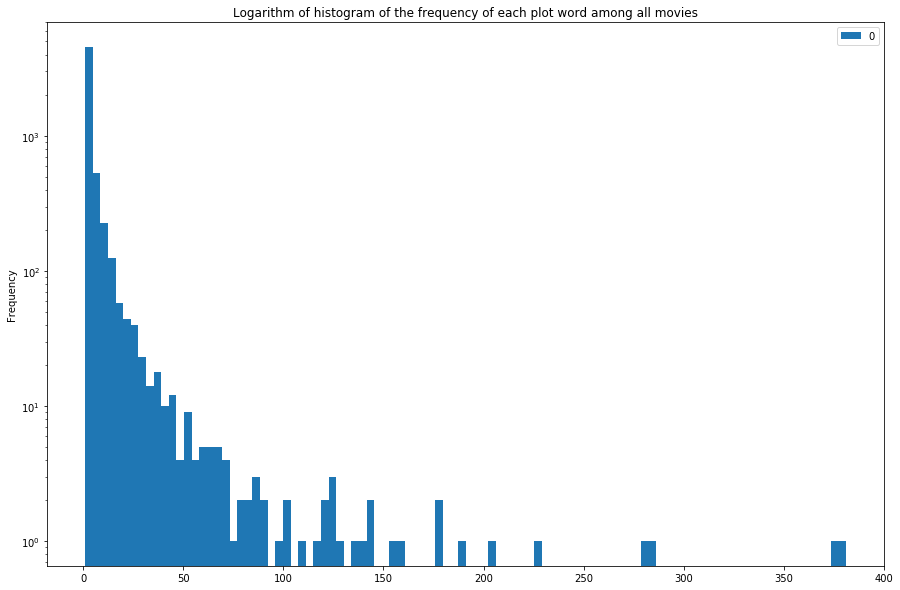

In [53]:
df.plot(kind='hist', bins=100, figsize=(15, 10), logy=True, 
        title='Logarithm of histogram of the frequency of each plot word among all movies')
plt.show()

In [50]:
df[df[0].apply(lambda x: x >= 100)]

,0
world,228
home,143
years,142
time,103
life,377
friends,178
man,381
team,119
daughter,117
friend,125


The most common words among all the movies are the ones listed above. As we can see, most words do not describe the story (man, woman, life, school) but the scenario and the characters. We decided that the plot is useful for the graph creation but not for the machine learning analysis. 

We will use the plot for the graph creation (two similar movies will be movies that have a lot of plot words in common).

We need to format the Awards feature. The current Awards column contains a string (sentence) describing how many awards the movie has won or has been nominated to. It also specifies if it has won or been nominated to Oscars or BAFTA. We believe that when it is specified, the higher "award" is listed, i.e. if the movie won 2 Oscars, the 5 Oscar nominations won't be specified. The most useful format we could think of is to transform this award column into 2 distinct columns, since we cannot infer how many nominations to the Oscars a movie has when it has already won some. The columns are hence: 

- Wins
- Nominations

In [78]:
def find_wins_nominations(string):
    wins = 0
    noms = 0
    
    splitted = string.split('. ')
    if len(splitted) > 1:
        string1 = splitted[0]
        if re.search('nominated', string1, re.IGNORECASE):
            noms = noms + int(string1.split(' ')[2])
        if re.search('won', string1, re.IGNORECASE):
            wins = noms + int(string1.split(' ')[1])
        
        string2 = splitted[1]
        if re.search('nomination', string2, re.IGNORECASE):
            noms = noms + int(string2.split(' nomination')[0].split(' ')[-1])
        if re.search('win', string2, re.IGNORECASE):
            wins = wins + int(string2.split(' win')[0].split(' ')[-1])
    elif len(splitted) == 1:
        split_string = splitted[0]
        if re.search('nomination', split_string, re.IGNORECASE):
            noms = noms + int(split_string.split(' nomination')[0].split(' ')[-1])
        if re.search('win', split_string, re.IGNORECASE):
            wins = wins + int(split_string.split(' win')[0].split(' ')[-1])
    return wins, noms

In [79]:
dataframe_['Wins'] = 0
dataframe_['Nominations'] = 0

for i in range(0, len(dataframe_)):
    wins, noms = find_wins_nominations(dataframe_.Awards[i])
    dataframe_['Wins'][i] = wins
    dataframe_['Nominations'][i] = noms
dataframe_ = dataframe_.drop(columns='Awards')

The Rated attribute is not uniform and has multiple conventions. We seek to normalize it. We decided to use the Motion Picture Association of America film rating system, which states that:

- **G: General Audiences. All ages admitted.** Nothing that would offend parents for viewing by children.
- **PG: Parental Guidance Suggested.** Some material may not be suitable for children. Parents urged to give "parental guidance". May contain some material parents might not like for their young children.
- **PG-13: Parents Strongly Cautioned.** Some material may be inappropriate for children under 13. Parents are urged to be cautious. Some material may be inappropriate for pre-teenagers.
- **R: Restricted. Under 17 requires accompanying parent or adult guardian.** Contains some adult material. Parents are urged to learn more about the film before taking their young children with them.
- **NC-17: Adults Only.** No One 17 and Under Admitted. Clearly adult. Children are not admitted.

https://en.wikipedia.org/wiki/Motion_Picture_Association_of_America_film_rating_system

**X** rating means persons under 16 not admitted. For our analysis, we decided to conflate that label within **NC-17**

Following this, we need to make some modifications: 

- Approved -> G
- GP -> PG
- M -> R
- Passed -> G
- TV-14 -> PG-13
- TV-G -> G
- TV-MA -> R
- TV-PG -> PG
- X -> NC-17
- Unrated, Not rated and N/A make up their own category **Unrated**

In [80]:
dataframe_['Rated'] = dataframe_['Rated'].str.replace('APPROVED', 'G')
dataframe_['Rated'] = dataframe_['Rated'].str.replace('GP', 'PG')
dataframe_['Rated'] = dataframe_['Rated'].str.replace('M', 'R')
dataframe_['Rated'] = dataframe_['Rated'].str.replace('PASSED', 'G')
dataframe_['Rated'] = dataframe_['Rated'].str.replace('TV-14', 'G')
dataframe_['Rated'] = dataframe_['Rated'].str.replace('APPROVED', 'PG-13')
dataframe_['Rated'] = dataframe_['Rated'].str.replace('TV-G', 'G')
dataframe_['Rated'] = dataframe_['Rated'].str.replace('TV-MA', 'R')
dataframe_['Rated'] = dataframe_['Rated'].str.replace('TV-PG', 'PG')
dataframe_['Rated'] = dataframe_['Rated'].str.replace('X', 'NC-17')
dataframe_['Rated'] = dataframe_['Rated'].str.replace('NOT RATED', 'UNRATED')
dataframe_['Rated'] = dataframe_['Rated'].str.replace('N/A', 'UNRATED')

In [81]:
dataframe_['Rated'] = dataframe_['Rated'].apply(lambda x: {x})

In order to make it easier to analyze, we decided to transform every foreign language into the label "Foreign" except from Spanish.

In [82]:
def format_languages(lang_set):
    if (lang_set - {'English', 'Spanish'}) != set(): # There are other things than English 
        if 'English' not in lang_set: # There is only other things than English
            if 'Spanish' not in lang_set:
                new_label = {'Other'}
            else: 
                new_label = {'Spanish', 'Other'}
        else:
            if 'Spanish' not in lang_set:
                new_label = {'English', 'Foreign'}
            else:
                new_label = {'English', 'Spanish', 'Other'}
    else:
        if 'English' not in lang_set:
            if 'Spanish' not in lang_set:
                new_label = set()
            else: 
                new_label = {'Spanish'}
        else:
            if 'Spanish' not in lang_set:
                new_label = {'English'}
            else:
                new_label = {'English', 'Spanish'}
    return new_label

In [83]:
dataframe_['Language'] = dataframe_['Language'].apply(lambda x: format_languages(x))

The Release date is still a string. In order to handle it and make computations with it, we need to transform its format.

In [84]:
def format_date(datestring):
    if datestring != 'N/A':
        splitted = datestring.split(' ')
        day = splitted[0]
        month = splitted[1]
        year = splitted[2]

        new_month = ''
        if month == 'Jan':
            new_month = '01'
        elif month == 'Feb':
            new_month = '02'
        elif month == 'Mar':
            new_month = '03'
        elif month == 'Apr':
            new_month = '04'
        elif month == 'May':
            new_month = '05'
        elif month == 'Jun':
            new_month = '06'
        elif month == 'Jul':
            new_month = '07'
        elif month == 'Aug':
            new_month = '08'
        elif month == 'Sep':
            new_month = '09'
        elif month == 'Oct':
            new_month = '10'
        elif month == 'Nov':
            new_month = '11'
        elif month == 'Dec':
            new_month = '12'

        return day+'/'+new_month+'/'+year
    else:
        return np.nan

In [85]:
dataframe_['Released'] = dataframe_['Released'].apply(lambda x: format_date(x))
dataframe_['Released'] = pd.to_datetime(dataframe_['Released'], format='%d/%m/%Y')

The countries are formatted so as to show 'USA' or 'Foreign'.

In [86]:
def format_country(country_set):
    if (country_set - {'USA'}) != set():
        if 'USA' not in country_set:
            new_label = {'Foreign'}
        else:
            new_label = {'USA', 'Foreign'}
    else:
        if 'USA' not in country_set:
            new_label = set()
        else:
            new_label = {'USA'}
    return new_label

In [87]:
dataframe_['Country'] = dataframe_['Country'].apply(lambda x: format_country(x))

In [88]:
dataframe_.to_pickle("df.pkl")

In [89]:
dataframe_ = pd.read_pickle("df.pkl")

Finally, we need to add the budget. For that, we use the budget column in the Kaggle imdb dataset.

In [90]:
FILE_PATH_MOVIE = "../Data/tmdb_5000_movies.csv"
movie_df = pd.read_csv(FILE_PATH_MOVIE)

budget_df = movie_df[['budget', 'title']]
budget_df = budget_df.rename(columns={"budget" : "Budget", "title" : "Title"})

final_df = dataframe_.merge(budget_df, how='inner')

In [91]:
final_df = final_df.drop(columns=['imdbID'])

In [92]:
final_df.to_pickle("final_df.pkl")

### Data cleaning results

We get a dataframe with the following features:

- Actors, Director, Writer
- Genre
- Budget
- Production
- Plot
- Country, Language
- Release date
- Runtime
- Rated category (PG-13, 18...)

Each movie has one identifyier:

- Title

And we have several labels that define the success of the movie:

- Box Office
- imdb Grade (+ imdb votes)
- Rotten Tomatoes Grade
- Metacritic Grade
- Wins and Nominations

# 3. ML

# 4. Graph creation

After data cleaning, we proceed to the creation of the graph by computing its adjacency matrix. We wish to create an adjacency matrix containing all features. We will hence compute several adjacency matrices that we will then add (using weighting factors). Such matrices are:

- Crew (actors, writers and directors): how many crew members the movies have in common
- Budget: the similarity between movies will be based on how close the budgets are (in a log scale)
- Genre: how many genres two movies have in common
- Production: is it the same production company?
- Plot: how many common words two films have in common
- Language: since the only two categories are English and Foreign, a score between 0 and 2 between 2 movies
- Country: how many countries in common 
- Runtime: the similarity between movies will be based on how close the runtimes are (in a log scale)
- Rated category: binary score = same category or different
- Release: the dissimilarity is how far apart the two movies are in time

In [93]:
final_df = pd.read_pickle("final_df.pkl")
final_df.head()

,Actors,BoxOffice,Country,Director,Genre,Language,Plot,Production,Rated,Released,Runtime,Title,Writer,imdbVotes,imdbGrade,tomatoGrade,metacriticGrade,Wins,Nominations,Budget
0,"{Zoe Saldana, Sigourney Weaver, Sam Worthingto...",749700000,"{USA, Foreign}",{James Cameron},"{Sci-Fi, Fantasy, Adventure, Action}","{Spanish, English}","{following, moon, protecting, feels, world, un...",{20th Century Fox},{PG-13},2009-12-18,162,Avatar,{James Cameron},1013715,78,82,83,88,128,237000000
1,"{Orlando Bloom, Geoffrey Rush, Johnny Depp, Ke...",309404152,{USA},{Gore Verbinski},"{Fantasy, Adventure, Action}",{English},"{Will, map, Barbossa, treacheryndtrayal, last,...",{Buena Vista},{PG-13},2007-05-25,169,Pirates of the Caribbean: At World's End,"{Ted Elliott, Stuart Beattie, Terry Rossio, Ja...",542125,71,44,50,20,46,300000000
2,"{Daniel Craig, Léa Seydoux, Christoph Waltz, R...",208777731,"{USA, Foreign}",{Sam Mendes},"{Thriller, Adventure, Action}","{Spanish, Other, English}","{missions, past, called, sends, events, pitted...",{Sony},{PG-13},2015-11-06,148,Spectre,"{Neal Purvis, Ian Fleming, Robert Wade, John L...",343533,68,64,60,8,32,245000000
3,"{Joseph Gordon-Levitt, Tom Hardy, Christian Ba...",448130642,"{USA, Foreign}",{Christopher Nolan},"{Thriller, Action}","{Foreign, English}","{now, edgetalnnihilation, exile, reignnarchy, ...",{Warner Bros},{PG-13},2012-07-20,164,The Dark Knight Rises,"{David S. Goyer, Bob Kane, Jonathan Nolan, Chr...",1344474,84,87,78,38,103,250000000
4,"{Samantha Morton, Lynn Collins, Willem Dafoe, ...",73058679,{USA},{Andrew Stanton},"{Sci-Fi, Adventure, Action}",{English},"{Civil, War, 12-foot, encounter, need, despera...",{Disney},{PG-13},2012-03-09,132,John Carter,"{Mark Andrews, Michael Chabon, Edgar Rice Burr...",234717,66,51,51,2,8,260000000


## A. Crew adjacency

In [494]:
weights_crew = np.zeros((len(final_df), len(final_df)))
weights_dir = np.zeros((len(final_df), len(final_df)))
weights_actors = np.zeros((len(final_df), len(final_df)))
weights_writer = np.zeros((len(final_df), len(final_df)))

In [495]:
for i in range(0, len(final_df)):
    for j in range(i+1, len(final_df)):
        weights_dir[i][j] = weights_dir[i][j] + len(final_df['Director'][i] & final_df['Director'][j])
weights_dir = weights_dir + weights_dir.T

for i in range(0, len(final_df)):
    for j in range(i+1, len(final_df)):
        weights_actors[i][j] = weights_actors[i][j] + len(final_df['Actors'][i] & final_df['Actors'][j])
weights_actors = weights_actors + weights_actors.T

for i in range(0, len(final_df)):
    for j in range(i+1, len(final_df)):
        weights_writer[i][j] = weights_writer[i][j] + len(final_df['Writer'][i] & final_df['Writer'][j])
weights_writer = weights_writer + weights_writer.T

In [504]:
# Add and save
weights_crew = weights_dir + weights_actors + weights_writer

np.save('weights_dir.npy', weights_dir)
np.save('weights_act.npy', weights_actors)
np.save('weights_wri.npy', weights_writer)
np.save('weights_crew.npy', weights_crew)

## B. Budget adjacency
### TODO: check the computing method

Two similar films are two films that have a similar budget. This is why we cannot use the absolute difference between the films as a similarity metric. 

Moreover, two films having a budget of millions but being 1 million dollars appart are more similar than a film having a budget of 10 dollars and a film having a budget of 1 million and 10 dollars. This is why before computing the absolute difference in budget, we must convert the budget to a logarithmic scale. 

Then, once the differences have been computed, the weight matrix has to be:
$ weights = max(weights) - weights$

In [553]:
weights_budget = np.zeros((len(final_df), len(final_df)))

for i in range(0, len(final_df)):
    for j in range(i+1, len(final_df)):
        weights_budget[i][j] = np.abs(np.log10(final_df['Budget'][i]) -  np.log10(final_df['Budget'][j]))

# Symmetrize
weights_budget = weights_budget + weights_budget.T
weights_budget = np.max(weights_budget) - weights_budget

# Save 
np.save('weights_budget.npy', weights_budget)

## C. Genre adjacency

In [505]:
weights_genre = np.zeros((len(final_df), len(final_df)))

for i in range(0, len(final_df)):
    for j in range(i+1, len(final_df)):
        weights_genre[i][j] = len(final_df['Genre'][i] & final_df['Genre'][j])

# Symmetrize
weights_genre = weights_genre + weights_genre.T

# Save 
np.save('weights_genre.npy', weights_genre)

## D. Production 

In [506]:
weights_prod = np.zeros((len(final_df), len(final_df)))

for i in range(0, len(final_df)):
    for j in range(i+1, len(final_df)):
        weights_prod[i][j] = len(final_df['Production'][i] & final_df['Production'][j])

# Symmetrize
weights_prod = weights_prod + weights_prod.T

# Save 
np.save('weights_prod.npy', weights_prod)

## E. Plot

In [507]:
weights_plot = np.zeros((len(final_df), len(final_df)))

for i in range(0, len(final_df)):
    for j in range(i+1, len(final_df)):
        weights_plot[i][j] = len(final_df['Plot'][i] & final_df['Plot'][j])

# Symmetrize
weights_plot = weights_plot + weights_plot.T

# Save 
np.save('weights_plot.npy', weights_plot)

## F. Country, Language

In [49]:
weights_lang = np.zeros((len(final_df), len(final_df)))

for i in range(0, len(final_df)):
    for j in range(i+1, len(final_df)):
        weights_lang[i][j] = len(final_df['Language'][i] & final_df['Language'][j])

for i in range(0, len(final_df)):
    for j in range(i+1, len(final_df)):
        weights_lang[i][j] = weights_lang[i][j] + len(final_df['Country'][i] & final_df['Country'][j])

# Symmetrize        
weights_lang = weights_lang + weights_lang.T

# Save
np.save('weights_lang.npy', weights_lang)

## G. Release date
### TODO: check computing method

In [590]:
weights_date = np.zeros((len(final_df), len(final_df)))

for i in range(0, len(final_df)):
    for j in range(i+1, len(final_df)):
        if (not pd.isnull(final_df['Released'][i])) and (not pd.isnull(final_df['Released'][j])):
            weights_date[i][j] = abs(final_df['Released'][i] - final_df['Released'][j]).days
        else:
            weights_date[i][j] = 37742

# Symmetrize        
weights_date = weights_date + weights_date.T

# Save
np.save('weights_date.npy', weights_date)

## H. Runtime
### TODO: check computing method

In [554]:
weights_runtime = np.zeros((len(final_df), len(final_df)))

for i in range(0, len(final_df)):
    for j in range(i+1, len(final_df)):
        weights_runtime[i][j] = np.abs(final_df['Runtime'][i] -  final_df['Runtime'][j])

# Symmetrize
weights_runtime = weights_runtime + weights_runtime.T
weights_runtime = np.max(weights_runtime) - weights_runtime

# Save 
np.save('weights_runtime.npy', weights_runtime)

## I. Rated category

In [552]:
weights_rated = np.zeros((len(final_df), len(final_df)))

for i in range(0, len(final_df)):
    for j in range(i+1, len(final_df)):
        weights_rated[i][j] = len(final_df['Rated'][i] & final_df['Rated'][j])

# Symmetrize
weights_rated = weights_rated + weights_rated.T

# Save 
np.save('weights_rated.npy', weights_rated)

In [4]:
weights_crew = np.load('weights_crew.npy')
weights_budget = np.load('weights_budget.npy')
weights_genre = np.load('weights_genre.npy')
weights_prod = np.load('weights_prod.npy')
weights_plot = np.load('weights_plot.npy')
weights_lang = np.load('weights_lang.npy')
weights_date = np.load('weights_date.npy')
weights_runtime = np.load('weights_runtime.npy')
weights_rated = np.load('weights_rated.npy')

## Total adjacency matrix

Now, we need to add all weight matrices. It is however of use to add them using weigh factors, as some features may be more important than others.

In [50]:
crew_factor = 1
budget_factor = 1
genre_factor = 1
prod_factor = 1
plot_factor = 1
lang_factor = 1
date_factor = 1
runtime_factor = 1
rated_factor = 1
sum_factors = (crew_factor + budget_factor + genre_factor + prod_factor + 
               plot_factor + lang_factor + date_factor + runtime_factor + rated_factor)

weights = (crew_factor*weights_crew + budget_factor*weights_budget + genre_factor*weights_genre + 
           prod_factor*weights_prod + plot_factor*weights_plot + lang_factor*weights_lang + 
           date_factor*weights_date + runtime_factor*weights_runtime + rated_factor*weights_rated) / sum_factors

# The adjacency matrix is the normalized weight matrix
adjacency = weights / np.max(weights)

# Save
np.save('weights.npy', weights)
np.save('adjacency.npy', adjacency)

In [6]:
weights = np.load('weights.npy')
adjacency = np.load('adjacency.npy')